# Packages

In [ ]:
# !pip install -U transformers pandas matplotlib seaborn scikit-learn

In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

from google.colab import drive



---


# Data

Read Categorical Filipino Online Disinformation Dataset

In [ ]:
drive.mount('/content/drive')
dir_path = '/content/drive/MyDrive/4th Year AY 2024-2025/First Semester/CS 198/'
# dir_path = 'D:\\Google Drive\\4th Year AY 2024-2025\\First Semester\\CS 198\\'

dataset_df = pd.read_csv(dir_path + 'CFODD.csv')
dataset_df

Mounted at /content/drive


,Headline,Hypothesis/Claims,Premise/Facts,Category,Label,Flip-Flop,Link
0,When did the anti-drugs campaign under Duterte...,"“And so even before I became a President, ther...","Project Double Barrel, the “official” anti-ill...",Politics,FAKE,False,https://verafiles.org/articles/vera-files-fact...
1,When did the anti-drugs campaign under Duterte...,"A day after Duterte become president, the PNP ...","Project Double Barrel, the “official” anti-ill...",Politics,FACT,False,https://verafiles.org/articles/vera-files-fact...
2,Aguirre blasts CHR head: Get your figures right,"Secretary Aguirre hit back at Gascon, question...",the Commission on Human Rights (CHR) cannot fi...,Politics,FAKE,False,https://verafiles.org/articles/vera-files-fact...
3,Is Aguirre correct in saying CHR should file c...,“You (CHR) make a finding and make recommendat...,the Commission on Human Rights (CHR) cannot fi...,Politics,FACT,False,https://verafiles.org/articles/vera-files-fact...
4,Was the UN probe on Duterte and the Davao Deat...,President Rodrigo Duterte said “Investigate me...,"Philip Alston, then the United Nations Special...",Politics,FAKE,False,https://verafiles.org/articles/vera-files-fact...
...,...,...,...,...,...,...,...
195,"No Japan T-4 fighter jet acquired, tested by PH",The Philippine Air Force did not receive and o...,"However, the only ceremonial turnover between ...",Politics,FACT,False,https://www.factrakers.org/post/no-japan-t-4-f...
196,Had surprised the Philippines Massive US milit...,US deploys hundreds of containers of missiles ...,The last known visit of US troops to the Dibac...,Politics,FAKE,False,https://www.factrakers.org/post/us-did-not-del...
197,US did not deliver hundreds of equipment to PH,The United States did not deploy hundreds of c...,The last known visit of US troops to the Dibac...,Politics,FACT,False,https://www.factrakers.org/post/us-did-not-del...
198,The US Aircarft Carrier (CVN-72 ) and 20 Briti...,The video showed a fleet of ships treading the...,The U.S. Navy’s most recent documentation of C...,Politics,FAKE,NaN,https://www.factrakers.org/post/us-maritime-dr...


Remove empty entries and take only the three columns -- Claims, Facts, Label

In [ ]:
df = dataset_df[['Hypothesis/Claims', 'Premise/Facts', 'Label']].dropna()

print(df.info())
print("\nNumber of NaN values per column:\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Hypothesis/Claims  200 non-null    object
 1   Premise/Facts      200 non-null    object
 2   Label              200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB
None

Number of NaN values per column:
 Hypothesis/Claims    0
Premise/Facts        0
Label                0
dtype: int64


## Quick Info: Bi-Encoder Vs Cross-Encoder Model Architecture
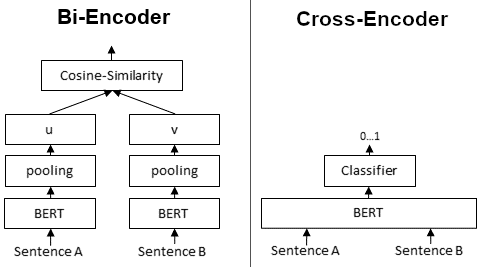

Taking inspiration from the **Cross-Encoder Architecture** to find the inference between a premise and a claim, the pair is concatenated with a given format before feeding to the model.

In [ ]:
candidate_labels = ['entailment', 'contradiction', 'neutral']
labels_array = df['Label'].str.lower()
claim_premise_pairs = [f"Premise: {row['Premise/Facts']}\nHypothesis: {row['Hypothesis/Claims']}".lower() for _, row in df.iterrows()]

print("Sample Pair:")
print("Premise: It is raining\nHypothesis: The grass is dry".lower())
pd.DataFrame({'Premise and Claim': claim_premise_pairs, 'Labels': labels_array})

Sample Pair:
premise: it is raining
hypothesis: the grass is dry


,Premise and Claim,Labels
0,"premise: project double barrel, the “official”...",fake
1,"premise: project double barrel, the “official”...",fact
2,premise: the commission on human rights (chr) ...,fake
3,premise: the commission on human rights (chr) ...,fact
4,"premise: philip alston, then the united nation...",fake
...,...,...
195,"premise: however, the only ceremonial turnover...",fact
196,premise: the last known visit of us troops to ...,fake
197,premise: the last known visit of us troops to ...,fact
198,premise: the u.s. navy’s most recent documenta...,fake




---


# Helper Functions

In [ ]:
def metrics(pred, true):
  label_map = {'fake': 0, 'fact': 1}
  true_numeric = [label_map[label] for label in true]
  pred_numeric = [label_map[label] for label in pred]

  accuracy = accuracy_score(true_numeric, pred_numeric)
  precision = precision_score(true_numeric, pred_numeric, average='binary')
  recall = recall_score(true_numeric, pred_numeric, average='binary')
  f1 = f1_score(true_numeric, pred_numeric, average='binary')

  print(f"Accuracy: {accuracy:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")
  print(f"F1 Score: {f1:.2f}")

  cm = confusion_matrix(true, pred, labels=['fake', 'fact'])
  sns.heatmap(cm, annot=True, fmt="d", cbar=False,
              xticklabels=['fake', 'fact'], yticklabels=['fake', 'fact'])
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
def details_of(results, true):
  predicted_labels = []
  predicted_scores = []
  for result in results:
    max_score_index = result['scores'].index(max(result['scores']))
    predicted_scores.append(result['scores'][max_score_index])
    predicted_label = result['labels'][max_score_index]

    if predicted_label == 'entailment':
      predicted_label = 'fact'
    else: predicted_label = 'fake'

    predicted_labels.append(predicted_label)

  correct_predictions = 0
  correct_array = []
  for i in range(len(predicted_labels)):
      if predicted_labels[i] == labels_array.iloc[i]:
          correct_predictions += 1
          correct_array.append(True)
      elif predicted_labels[i] == labels_array.iloc[i]:
          correct_predictions += 1
          correct_array.append(True)
      else:
          correct_array.append(False)

  metrics(predicted_labels, true)

  comparison_df = pd.DataFrame({'labels_array': labels_array, 'predicted_labels': predicted_labels, 'predicted_scores': predicted_scores, 'is_correct': correct_array})
  return comparison_df



---

## Quick Info: Text Classfication vs Zero-Shot Classification TLDR

*   Use Text Classification to predict an input from **label/s trained on** by a scoring mechanism
*   Use Zero-Shot Classification to predict an input from **never-seen-before labels** by a probability mechanism

## In the context of Natural Language Inference (NLI)

NLI is an NLP task, and it is usually done through text classification. However, there are no existing multilingual NLI pre-trained models to use as baseline. Hence multilingual pre-trained models are utilized with Zero-shot classification, giving them a candidate labels of {fake, fact}.

## Models to experiment on: Transformer Models
As of today, transformer models are the state of the art models when it comes to NLP tasks. In this study, we used one of each encoder-only, encoder-decoder, and decoder-only transformer models. That is, **XLM-RoBERTa, mT5, and GPT4o-mini** were experimented, respectively.



---


# Model XLM-RoBERTa (Encoder-only Transformer Model)

In [ ]:
pl_xlm_zsc = pipeline("zero-shot-classification", model="facebookAI/xlm-roberta-large")

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at facebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Accuracy: 0.51
Precision: 0.75
Recall: 0.03
F1 Score: 0.06


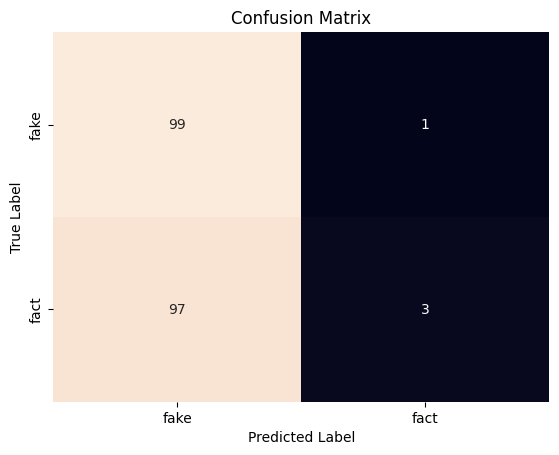

,labels_array,predicted_labels,predicted_scores,is_correct
0,fake,fake,0.333462,True
1,fact,fake,0.333663,False
2,fake,fake,0.333569,True
3,fact,fake,0.333738,False
4,fake,fake,0.333628,True
...,...,...,...,...
195,fact,fake,0.336222,False
196,fake,fake,0.333844,True
197,fact,fake,0.333737,False
198,fake,fake,0.333882,True


In [ ]:
xlm_results = []
for claim in claim_premise_pairs:
  result = pl_xlm_zsc(claim, candidate_labels)
  xlm_results.append(result)

details_of(xlm_results, labels_array)



---


# Model mT5 (Encoder-Decoder Transformer Model)

In [ ]:
pl_zsc = pipeline("zero-shot-classification", model="google/mt5-xl")

Some weights of MT5ForSequenceClassification were not initialized from the model checkpoint at google/mt5-xl and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [ ]:
mt5_results = []
for i,claim in enumerate(claim_premise_pairs):
  print(i)
  result = pl_zsc(claim, candidate_labels)
  mt5_results.append(result)

details_of(mt5_results, labels_array)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [ ]:
details_of(mt5_results, labels_array)

ValueError: Found input variables with inconsistent numbers of samples: [200, 9]

# GPT4o-mini

Used separate for clarity:
https://colab.research.google.com/drive/15g9ol5NcdFmzWMBGi8NEelJO_A800mq0?usp=sharing